## Imports

In [1]:
import sys
import numba
import numpy as np
import pandas as pd
from math import e
from os.path import abspath, join as opj
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
from umap import UMAP

sys.path.insert(0, abspath('../helpers/'))
from participant import Participant, symmetric_kl
from experiment import Experiment

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Set paths & params

In [2]:
embeddings_dir = '../../data/embeddings'
models_dir = '../../data/models/'
fig_dir = '../../paper/figs/'

plt.rcParams['pdf.fonttype'] = 42
sns.set_context('paper')
# cmap = 'rocket'

## Define functions

In [3]:
@numba.njit(fastmath=True)
def euclidean_exp(x, y):
    x = e ** x
    y = e ** y
    result = 0.0
    for i in range(x.shape[0]):
        result += (x[i] - y[i]) ** 2
    d = np.sqrt(result)
    grad = (x - y) / (1e-6 + d)
    return d, grad

In [4]:
@numba.njit(fastmath=True)
def symmetric_kl_exp(x, y, z=1e-11):
    x = e ** x
    y = e ** y
    n = x.shape[0]
    x_sum = 0.0
    y_sum = 0.0
    kl1 = 0.0
    kl2 = 0.0

    for i in range(n):
        x[i] += z
        x_sum += x[i]
        y[i] += z
        y_sum += y[i]

    for i in range(n):
        x[i] /= x_sum
        y[i] /= y_sum

    for i in range(n):
        kl1 += x[i] * np.log(x[i] / y[i])
        kl2 += y[i] * np.log(y[i] / x[i])

    dist = (kl1 + kl2) / 2
    grad = (np.log(y / x) - (x / y) + 1) / 2
    return dist, grad

## Load data

In [5]:
exp = Experiment()
exp.load_lecture_trajs()
exp.load_question_vectors()
exp.load_participants(load_avg=True)
participants = exp.participants
avg_participant = exp.avg_participant
n_topics = exp.lda_params['n_components']
umap_params = exp.umap_params
seed = umap_params['random_state']
umap_params['metric'] = symmetric_kl_exp
print(umap_params)

{'n_components': 2, 'n_neighbors': 15, 'min_dist': 0.7, 'spread': 1.0, 'random_state': 0, 'metric': CPUDispatcher(<function euclidean_exp at 0x7f80fc55e7a0>)}


## Create 2D embeddings

In [6]:
# concatenate all data along fetaure dimension to embed in a shared space
to_reduce = exp.get_lecture_traj(['forces', 'bos'])
to_reduce.extend(list(exp.get_question_vecs(lectures=['forces', 'bos', 'general'])))
# store data incidces to separate embedded matrix later
split_inds = np.cumsum([np.atleast_2d(vec).shape[0] for vec in to_reduce])[:2]
to_reduce = np.log(np.vstack(to_reduce))

In [8]:
np.random.seed(seed)
reducer = UMAP(verbose=True, **umap_params).fit(to_reduce)
embeddings = reducer.embedding_
forces_emb, bos_emb, questions_embs = np.vsplit(embeddings, split_inds)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False,
     metric=CPUDispatcher(<function euclidean_exp at 0x7f80fc55e7a0>),
     metric_kwds=None, min_dist=0.7, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Thu Mar  5 18:36:44 2020 Finding Nearest Neighbors
Thu Mar  5 18:36:46 2020 Finished Nearest Neighbor Search
Thu Mar  5 18:36:48 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 

In [27]:
# save fit UMAP reducer and 2D embeddings
# np.save(opj(models_dir, 'UMAP_reducer'), reducer)
# np.save(opj(embeddings_dir, 'forces_lecture'), forces_emb)
# np.save(opj(embeddings_dir, 'bos_lecture'), bos_emb)
# np.save(opj(embeddings_dir, 'questions'), questions_embs)
# exp.load_reducer()
# exp.load_embeddings()

## Create a 2D grid

In [9]:
resolution = 50
x_min, y_min = embeddings.min(axis=0) // 1
x_max, y_max = embeddings.max(axis=0) // 1 + 1
x_step = (x_max - x_min) / resolution
y_step = (y_max - y_min) / resolution
xs = np.arange(x_min, x_max, x_step)
ys = np.arange(y_min, y_max, y_step)

X, Y = np.meshgrid(xs, ys)
xy_grid = np.empty((resolution, resolution, 2), dtype=np.float64)
for (x_ix, y_ix), X_val in np.ndenumerate(X):
    xy_grid[x_ix, y_ix] = (X_val, Y[x_ix, y_ix])

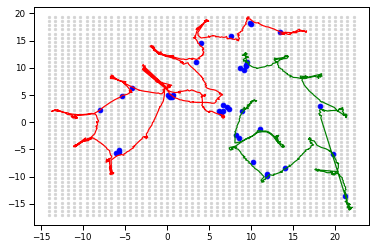

In [10]:
vertices = xy_grid.reshape(resolution**2, 2)

plt.scatter(vertices[:, 0], vertices[:, 1], c='lightgrey', marker='.')
plt.plot(forces_emb[:, 0], forces_emb[:, 1], 'r-')
plt.plot(bos_emb[:, 0], bos_emb[:, 1], 'g-')
plt.scatter(questions_embs[:, 0], questions_embs[:, 1], c='b', marker='o')

## Recover a topic vector for each grid point

In [47]:
# inverse-transform grid into original topic space
np.random.seed(reducer.transform_seed)
topic_space_vertices = reducer.inverse_transform(vertices)
topic_space_grid = topic_space_vertices.reshape(resolution, resolution, n_topics)
# make sure inverse transform was successful at all coordinates (failure returns all 0's)
assert ~np.all(np.equal(topic_space_grid, 0), axis=2).any()

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


## Reconstruct memory traces for every grid point

In [73]:
maps_arr = np.empty((3, exp.n_participants, resolution, resolution), dtype=np.float64)
for qset in range(3):
    store_key = f'kmap_qset{qset}'
    for i, p in enumerate(tqdm(participants, desc=f'{qset+1}/3', leave=False)):
        knowledge_map = p.reconstruct_trace(exp, content=topic_space_vertices, qset=qset)
        knowledge_map = knowledge_map.reshape(resolution, resolution)
        p.store_trace(knowledge_map, store_key)
        maps_arr[qset, i] = knowledge_map
    # store average in avg participant object
    avg_participant.store_trace(maps_arr[qset].mean(axis=0), store_key)

# exp.participants = participants
# exp.avg_participant = avg_participant

In [164]:
p = participants[0]
data = p.get_data(qset=0, lecture=None)
acc = data['accuracy'].astype(bool)
qids = data['qID'].tolist()
question_vecs = exp.get_question_vecs(qids=qids)
content = flat_topic_grid

In [671]:
n_questions = len(questions_df.loc[questions_df.video.isin([1, 2])])
participant_IDs = sorted(data_df.participantID.unique())

In [672]:
question_corr_grid = np.empty((n_questions, X.shape[0], X.shape[1]))
all_questions_vectors = list(forces_qs) + list(bos_qs)

for q_n, q_vector in enumerate(all_questions_vectors):
    for x_ix in range(X.shape[0]):
        for y_ix in range(X.shape[1]):
            question_corr_grid[q_n, x_ix, y_ix] = pearsonr(q_vector, topic_space_grid[x_ix, y_ix])[0]

In [681]:
for set_n in range(3):
    questions_pcorrect = np.empty(n_questions)
    for question in range(n_questions):
        # questions 1 - 30 pertain to lectures
        set_views = data_df.loc[(data_df.qID == question + 1) & (data_df['set'] == set_n)]
        p_correct = len(set_views.loc[set_views['correct?'] == 1]) / len(set_views)
        questions_pcorrect[question] = p_correct
        
    # compute weighted proportion of correctly answered questions for ecah grid point
    # weights are correlation between grid point topic vector and question vector
    knowledge_grid = np.zeros_like(X)
    weight_sum = question_corr_grid.sum(axis=0)
    knowledge_grid = (questions_pcorrect * question_corr_grid.T).sum(axis=2) / weight_sum
    break
    

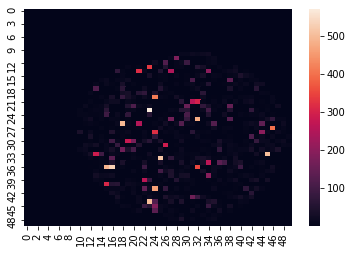

In [649]:
sns.heatmap(topic_space_grid.var(axis=2))

In [644]:
np.var

array([0.00152635, 0.00152631, 0.0015263 , 0.00152632, 0.00152629,
       0.0015263 , 0.0015263 , 0.00356824, 0.20046054, 0.00152631,
       0.5624761 , 0.0015263 ], dtype=float32)

In [639]:
q_vector

array([0.86904477, 0.01190482, 0.01190477, 0.01190477, 0.0119048 ,
       0.01190521, 0.01190477, 0.01190485, 0.01190527, 0.01190521,
       0.01190529, 0.01190548])

In [635]:
question_corr_grid[0, 0]

array([0.90198459, 0.90198457, 0.90198459, 0.90198457, 0.9019846 ,
       0.90198459, 0.90198458, 0.9019846 , 0.90198459, 0.90198458,
       0.90198462, 0.90198461, 0.90198461, 0.90198461, 0.90198457,
       0.90198461, 0.90198458, 0.90198461, 0.90198461, 0.90198461,
       0.90198461, 0.90198458, 0.90198459, 0.90198459, 0.90198458,
       0.9019846 , 0.90198459, 0.90198461, 0.90198462, 0.90198459,
       0.90198463, 0.90198458, 0.90198458, 0.90198459, 0.90198459,
       0.90198459, 0.90198459, 0.90198459, 0.90198459, 0.90198456,
       0.90198456, 0.90198456, 0.90198456, 0.90198464, 0.90198457,
       0.90198463, 0.9019846 , 0.90198461, 0.90198461, 0.90198463])

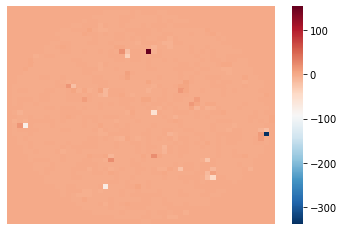

In [682]:
sns.heatmap(knowledge_grid, cmap=plt.cm.RdBu_r, xticklabels=[], yticklabels=[])
plt.show()

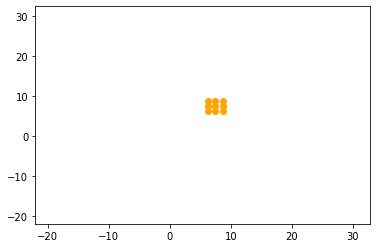

In [335]:
plt.scatter(np.vstack(embeddings)[:, 0], np.vstack(embeddings)[:, 1], c='white')
plt.scatter(all_zeros[:, 0], all_zeros[:, 1], c='orange')
plt.show()